<a href="https://colab.research.google.com/github/EmilSeyfullayev/Computer-Vision-Basics/blob/main/Yolo_with_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [ ]:
!git clone https://github.com/anushkadhiman/YOLOv3-TensorFlow-2.x.git 

In [ ]:
%cd YOLOv3-TensorFlow-2.x

In [3]:
# import os
# os.listdir()

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd YOLOv3-TensorFlow-2.x

In [ ]:
!wget -P model_data https://pjreddie.com/media/files/yolov3.weights

### Implementation

In [ ]:
!python detection_demo.py

In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import tensorflow as tf
from yolov3.utils import detect_image, detect_realtime, detect_video, Load_Yolo_model, detect_video_realtime_mp
from yolov3.configs import *

In [ ]:
image_path   = "image.jpg"
video_path   = "test.mp4"

In [ ]:
yolo = Load_Yolo_model()

In [ ]:
yolo.output

[<tf.Tensor 'concat_4:0' shape=(None, None, None, 3, 85) dtype=float32>,
 <tf.Tensor 'concat_7:0' shape=(None, None, None, 3, 85) dtype=float32>,
 <tf.Tensor 'concat_10:0' shape=(None, None, None, 3, 85) dtype=float32>]

In [ ]:
a = detect_image(yolo, image_path, "detect.jpg", input_size=YOLO_INPUT_SIZE, rectangle_colors=(255,0,0))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
a.shape

(787, 1180, 3)

In [ ]:
YOLO_INPUT_SIZE

416

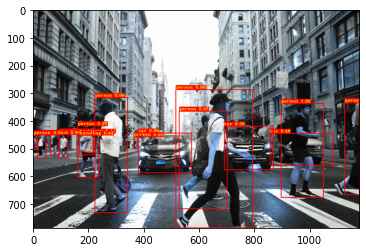

In [ ]:
plt.imshow(a)

# Component functions of YOLO utils.py

### YOLO.PY

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from tensorflow.keras.regularizers import l2
from yolov3.configs import *

STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T


def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

class BatchNormalization(BatchNormalization):
    # "Frozen state" and "inference mode" are two separate concepts.
    # `layer.trainable = False` is to freeze the layer, so the layer will use
    # stored moving `var` and `mean` in the "inference mode", and both `gama`
    # and `beta` will not be updated !
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    if downsample:
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        conv = LeakyReLU(alpha=0.1)(conv)

    return conv

def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    residual_output = short_cut + conv
    return residual_output

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')


def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3,  3,  32))
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

def darknet19_tiny(input_data):
    input_data = convolutional(input_data, (3, 3, 3, 16))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 16, 32))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 32, 64))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 64, 128))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 128, 256))
    route_1 = input_data
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 256, 512))
    input_data = MaxPool2D(2, 1, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 512, 1024))

    return route_1, input_data

def YOLOv3(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, route_2, conv = darknet53(input_layer)
    # See the orange module (DBL) in the figure above, a total of 5 Subconvolution operation
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 13, 13, 255] 
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)
    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # conv_mbbox is used to predict medium-sized objects, shape = [None, 26, 26, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)
    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # conv_sbbox is used to predict small size objects, shape = [None, 52, 52, 255]
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
        
    return [conv_sbbox, conv_mbbox, conv_lbbox]

def YOLOv3_tiny(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, conv = darknet19_tiny(input_layer)

    conv = convolutional(conv, (1, 1, 1024, 256))
    conv_lobj_branch = convolutional(conv, (3, 3, 256, 512))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 26, 26, 255]
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)
    
    conv = tf.concat([conv, route_1], axis=-1)
    conv_mobj_branch = convolutional(conv, (3, 3, 128, 256))
    # conv_mbbox is used to predict medium size objects, shape = [None, 13, 13, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_mbbox, conv_lbbox]

def Create_Yolov3(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    if TRAIN_YOLO_TINY:
        conv_tensors = YOLOv3_tiny(input_layer, NUM_CLASS)
    else:
        conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    YoloV3 = tf.keras.Model(input_layer, output_tensors)
    return YoloV3

def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box 

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    # Calculate the iou value between the two bounding boxes
    iou = inter_area / union_area

    # Calculate the coordinates of the upper left corner and the lower right corner of the smallest closed convex surface
    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # Calculate the area of the smallest closed convex surface C
    enclose_area = enclose[..., 0] * enclose[..., 1]

    # Calculate the GIoU value according to the GioU formula  
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

# testing (should be better than giou)
def bbox_ciou(boxes1, boxes2):
    boxes1_coor = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_coor = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left = tf.maximum(boxes1_coor[..., 0], boxes2_coor[..., 0])
    up = tf.maximum(boxes1_coor[..., 1], boxes2_coor[..., 1])
    right = tf.maximum(boxes1_coor[..., 2], boxes2_coor[..., 2])
    down = tf.maximum(boxes1_coor[..., 3], boxes2_coor[..., 3])

    c = (right - left) * (right - left) + (up - down) * (up - down)
    iou = bbox_iou(boxes1, boxes2)

    u = (boxes1[..., 0] - boxes2[..., 0]) * (boxes1[..., 0] - boxes2[..., 0]) + (boxes1[..., 1] - boxes2[..., 1]) * (boxes1[..., 1] - boxes2[..., 1])
    d = u / c

    ar_gt = boxes2[..., 2] / boxes2[..., 3]
    ar_pred = boxes1[..., 2] / boxes1[..., 3]

    ar_loss = 4 / (np.pi * np.pi) * (tf.atan(ar_gt) - tf.atan(ar_pred)) * (tf.atan(ar_gt) - tf.atan(ar_pred))
    alpha = ar_loss / (1 - iou + ar_loss + 0.000001)
    ciou_term = d + alpha * ar_loss

    return iou - ciou_term


def compute_loss(pred, conv, label, bboxes, i=0, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1 - giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    # Find the value of IoU with the real box The largest prediction box
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    # If the largest iou is less than the threshold, it is considered that the prediction box contains no objects, then the background box
    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < YOLO_IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    # Calculate the loss of confidence
    # we hope that if the grid contains objects, then the network output prediction box has a confidence of 1 and 0 when there is no object.
    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss

def Create_Yolo(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    if TRAIN_YOLO_TINY:
        if YOLO_TYPE == "yolov3":
            conv_tensors = YOLOv3_tiny(input_layer, NUM_CLASS)
    else:
        if YOLO_TYPE == "yolov3":
            conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    Yolo = tf.keras.Model(input_layer, output_tensors)
    return Yolo


### Trying model functions one by one

In [5]:
import cv2

In [6]:
image = cv2.imread('image.jpg')

In [13]:
image = image_preprocess(image, (416, 416))

In [17]:
darknet_output = darknet53(tf.expand_dims(image, 0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [20]:
np.array(darknet_output).shape

(3, 1)

In [25]:
darknet_output[0].shape

TensorShape([1, 52, 52, 256])

In [26]:
darknet_output[1].shape

TensorShape([1, 26, 26, 512])

In [27]:
darknet_output[2].shape

TensorShape([1, 13, 13, 1024])

In [34]:
yolo_output = YOLOv3(tf.expand_dims(image, 0), 80)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [38]:
yolo_output[0].shape

TensorShape([1, 52, 52, 255])

In [39]:
yolo_output[1].shape

TensorShape([1, 26, 26, 255])

In [40]:
yolo_output[2].shape

TensorShape([1, 13, 13, 255])

In [44]:
decode_output = decode(yolo_output[0], 80, 0) # index 0

In [50]:
decode_output.shape

TensorShape([1, 52, 52, 3, 85])

In [49]:
decode_output[0, 0, 0, 0, :]

<tf.Tensor: shape=(85,), dtype=float32, numpy=
array([  4. , 108. ,  33. ,  23. ,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,   0.5,
         0.5,   0.5,   0.5,   0.5], dtype=float32)>

### image_preprocess

In [9]:
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

In [ ]:
import cv2

In [ ]:
image = cv2.imread('image.jpg')

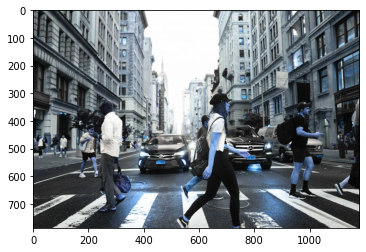

In [ ]:
plt.imshow(image)

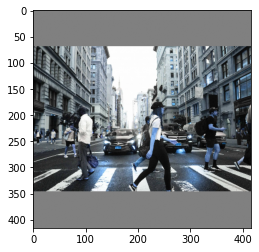

In [ ]:
plt.imshow(image_preprocess(image, (416,416)))

In [ ]:
ih, iw    = (416, 416)
h,  w, _  = image.shape

In [ ]:
scale = min(iw/w, ih/h)
scale

0.3525423728813559

In [ ]:
ih/h

0.5285895806861499

In [ ]:
iw/w

0.3525423728813559

In [ ]:
nw, nh  = int(scale * w), int(scale * h)
image_resized = cv2.resize(image, (nw, nh))

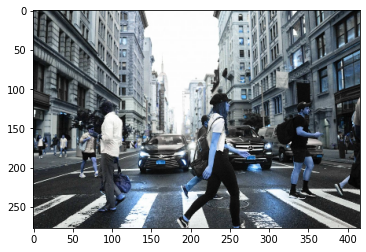

In [ ]:
plt.imshow(image_resized)

In [ ]:
image_resized.shape

(277, 416, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 3)


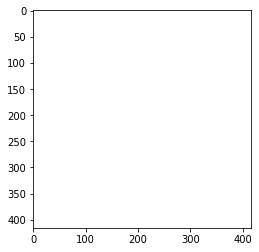

In [ ]:
image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
print(image_paded.shape)
plt.imshow(image_paded, cmap='gray')

In [ ]:
image_paded[:, 0, 0]

array([128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 12

In [ ]:
(ih-nh) // 2

69

In [ ]:
dw, dh = (iw - nw) // 2, (ih-nh) // 2

In [ ]:
nh

277

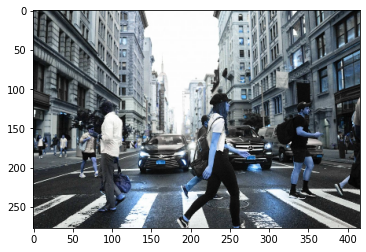

In [ ]:
plt.imshow(image_resized)

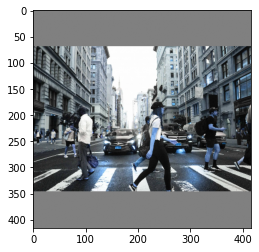

In [ ]:
image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
image_paded = image_paded / 255.
plt.imshow(image_paded)

In [ ]:
image_resized

array([[[ 90,  97, 100],
        [ 98, 103, 108],
        [ 92,  95, 103],
        ...,
        [ 10,  15,  14],
        [  7,  17,  14],
        [ 15,  25,  25]],

       [[ 31,  38,  41],
        [ 37,  42,  47],
        [ 37,  40,  47],
        ...,
        [  9,  16,  15],
        [ 26,  37,  35],
        [ 33,  44,  46]],

       [[ 88,  97, 100],
        [ 97, 103, 108],
        [100, 106, 113],
        ...,
        [ 25,  33,  35],
        [ 32,  44,  46],
        [ 45,  57,  61]],

       ...,

       [[ 30,  32,  34],
        [ 29,  31,  33],
        [ 32,  34,  36],
        ...,
        [ 30,  30,  30],
        [ 28,  28,  28],
        [ 29,  29,  29]],

       [[ 30,  33,  38],
        [ 38,  41,  45],
        [ 35,  38,  41],
        ...,
        [ 33,  33,  33],
        [ 36,  36,  36],
        [ 38,  36,  35]],

       [[ 36,  38,  48],
        [ 40,  40,  46],
        [ 33,  32,  34],
        ...,
        [ 21,  21,  21],
        [ 25,  25,  25],
        [ 28,  28,  28]]

### draw_bbox

In [ ]:
from multiprocessing import Process, Queue, Pipe
import cv2
import time
import random
import colorsys
import numpy as np
import tensorflow as tf
from yolov3.configs import *
from yolov3.yolov3 import *
from tensorflow.python.saved_model import tag_constants

In [ ]:
YOLO_COCO_CLASSES = 'model_data/coco/coco.names'

In [ ]:
def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

In [ ]:
def draw_bbox(image, bboxes, CLASSES=YOLO_COCO_CLASSES, show_label=True,\
              show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

### bboxes_iou

In [ ]:
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

### nms

In [ ]:
def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

### postprocess_boxes

In [ ]:
def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

### detect_image

In [ ]:
def detect_image(Yolo, image_path, output_path, input_size=416, show=False, CLASSES=YOLO_COCO_CLASSES, score_threshold=0.3,\
                 iou_threshold=0.45, rectangle_colors=''):
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)

    if YOLO_FRAMEWORK == "tf":
        pred_bbox = Yolo.predict(image_data)
    elif YOLO_FRAMEWORK == "trt":
        batched_input = tf.constant(image_data)
        result = Yolo(batched_input)
        pred_bbox = []
        for key, value in result.items():
            value = value.numpy()
            pred_bbox.append(value)
        
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    bboxes = nms(bboxes, iou_threshold, method='nms')

    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
    # CreateXMLfile("XML_Detections", str(int(time.time())), original_image, bboxes, read_class_names(CLASSES))

    if output_path != '': cv2.imwrite(output_path, image)
    if show:
        # Show the image
        cv2.imshow("predicted image", image)
        # Load and hold the image
        cv2.waitKey(0)
        # To close the window after the required kill value was provided
        cv2.destroyAllWindows()
        
    return image